#   HOUSE PRICE PREDICTION NOTEBOOK

## Import Libraries

In [30]:
import os, glob, matplotlib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold, train_test_split
import xgboost
import shap

import warnings
warnings.filterwarnings("ignore")


from Functions.preprocessing import *
from Functions.visualization import *

## Get the Data

In [31]:
TRAINDATAPATH = f'{os.getcwd()}/Data/train.csv'
TESTDATAPATH = f'{os.getcwd()}/Data/test.csv'

In [32]:
dfTrain=pd.read_csv(TRAINDATAPATH)
dfTest=pd.read_csv(TESTDATAPATH)

In [33]:
dfTrain

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,1456,60,RL,62.0,7917,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,8,2007,WD,Normal,175000
1456,1457,20,RL,85.0,13175,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,MnPrv,NaN,0,2,2010,WD,Normal,210000
1457,1458,70,RL,66.0,9042,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,GdPrv,Shed,2500,5,2010,WD,Normal,266500
1458,1459,20,RL,68.0,9717,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,4,2010,WD,Normal,142125


## Descriptive Analysis

In [34]:
dfTrain.dtypes.value_counts()

object     43
int64      35
float64     3
dtype: int64

In [6]:
dfTrain["SalePrice"] = np.log10(dfTrain["SalePrice"])

In [35]:
dfNumeric = dfTrain.select_dtypes(["int64", "float64"])
dfObject = dfTrain.select_dtypes("object")

In [36]:
dfObject = handleNans(dfObject, ratio=0.2)
dfNumeric = handleNans(dfNumeric, ratio=0.2)

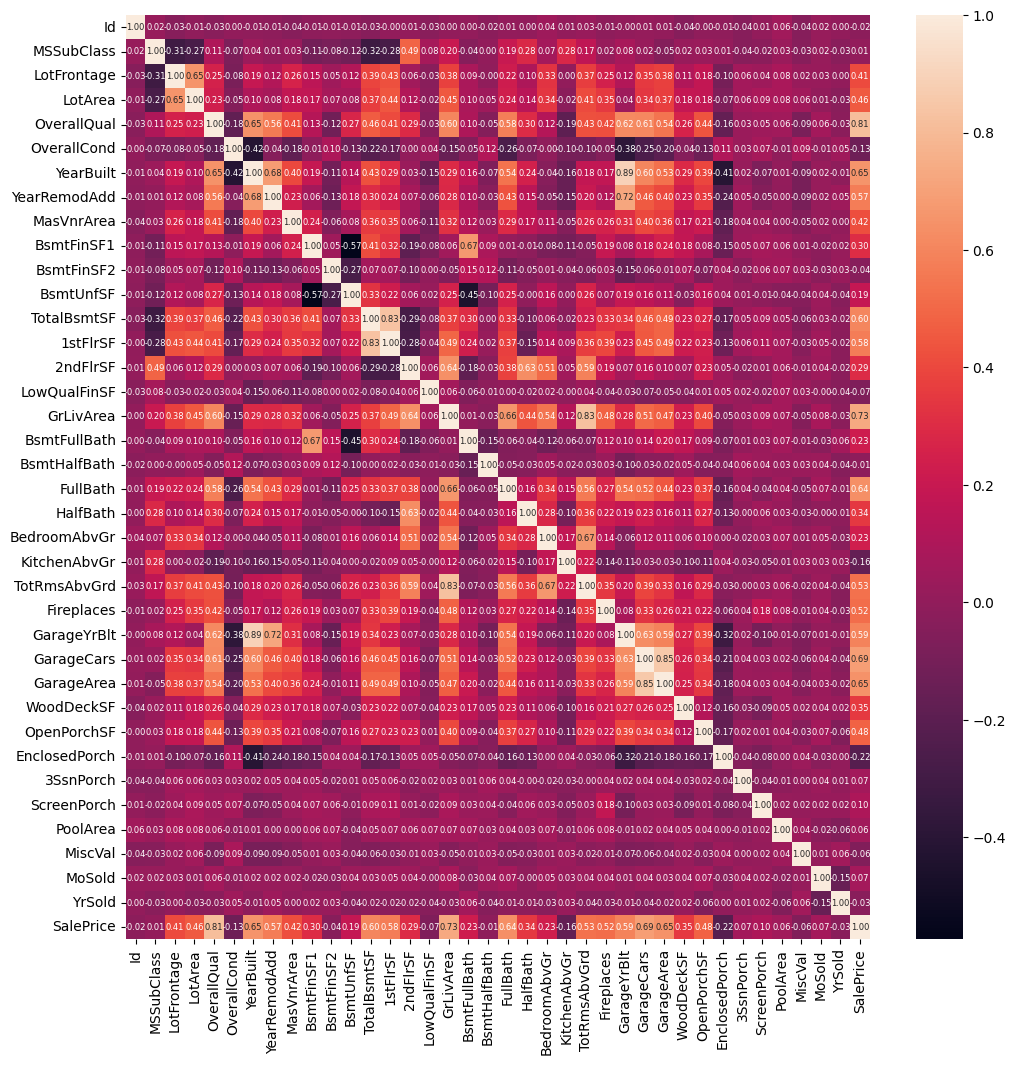

In [43]:
fig, ax = plt.subplots(1,1, figsize=(12,12))
sns.heatmap(dfNumeric.corr(method="spearman"), ax=ax, annot=True, annot_kws={"size":6}, fmt='.2f')
plt.show()

In [9]:
dfObject["SalePrice"] = dfNumeric["SalePrice"]

In [10]:
dfObject, _ = mergeSmallCategories(dfObject)

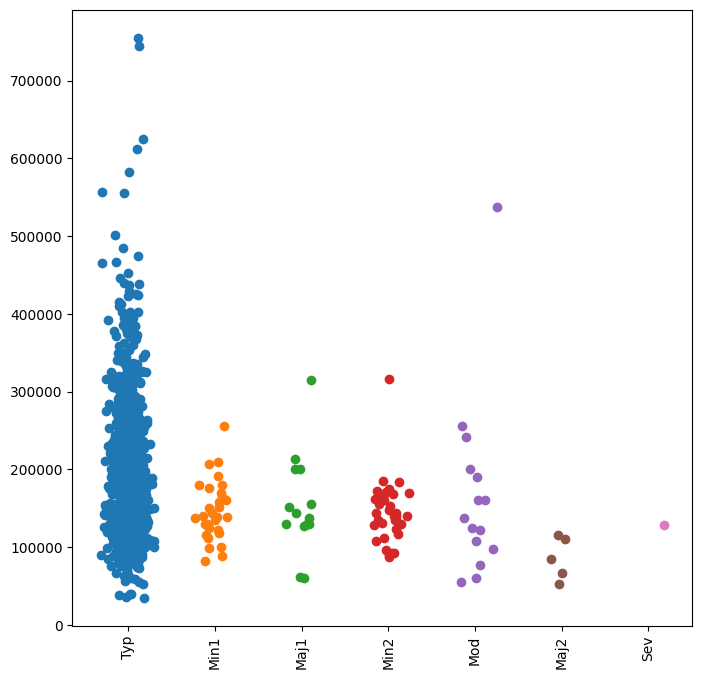

In [10]:
ax = visualizeByGroup(dfObject, "Functional")
plt.show()

In [11]:
dfNumeric, _ = fillNumericNans(dfNumeric)

LotFrontage
-----------
* (594.4183057403077, 589.2581203146698) 

GarageYrBlt
-----------
* (164.0201376316392, 609.1404623690802) 

MasVnrArea
----------
* Added Mean



In [12]:
dfObject = dfObject.fillna("Unknown")

In [13]:
def encode(dataframe:pd.DataFrame) -> pd.DataFrame:
    df_ = dataframe.copy()
    df = df_.select_dtypes("object")
    labelSeries = df_.loc[:, ~df_.columns.isin(df.columns)]

    enc = OneHotEncoder(drop="first", sparse=False)
    encodedMatrix =  enc.fit_transform(df)
    dfEncoded = pd.DataFrame(encodedMatrix, columns=enc.get_feature_names_out())
    return pd.concat([dfEncoded, labelSeries], axis=1), enc

dfObject, _ = encode(dfObject)

In [14]:
dfObject.drop(["SalePrice"], axis=1, inplace=True)

In [15]:
dfMerged = dfObject.merge(dfNumeric, left_index=True, right_index=True)

In [16]:
regressorCols = dfMerged.loc[:, ~dfMerged.columns.isin(["SalePrice"])].columns
errs = []

for train, test in KFold(9, shuffle=True, random_state=42).split(dfMerged):
    X_train, X_test, y_train, y_test = dfMerged.iloc[train][regressorCols], dfMerged.iloc[test][regressorCols], dfMerged.iloc[train]["SalePrice"], dfMerged.iloc[test]["SalePrice"]
    scaler = MinMaxScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    model = xgboost.XGBRegressor(n_estimators=1000, max_depth=7, eta=0.1, subsample=0.7, colsample_bytree=0.8)
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    err = mean_squared_error(y_test, preds, squared=False)
    errs.append(err)

print("MSE is:", np.array(errs).mean())

MSE is: 27601.020404309293


In [ ]:
# MSE is: 984798903.3594941 => With merged Categorized Columns / With log10 of Saleprice col
# MSE is: 1013374074.1716235 => W/O merged Categorized Columns / With log10 of Saleprice col
# MSE is: 875238162.5820205 => With merged Categorized Columns / W/O log10 of SalePrice col
# MSE is: 866795789.0594722 | RMSE is: 27601.020404309293  => W/O merged Categorized Columns / W/O log10 of SalePrice col

## SHAP Exploratory Analysis

In [17]:
labelCol = "SalePrice"
trainCols = dfMerged.loc[:, ~dfMerged.columns.isin([labelCol])].columns.tolist()
X_train, X_test, y_train, y_test = train_test_split(dfMerged[trainCols], dfMerged[labelCol], test_size=0.33, random_state=42)
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
X_train = pd.DataFrame(X_train, columns=trainCols)
X_test = pd.DataFrame(X_test, columns=trainCols)

model = xgboost.XGBRegressor(n_estimators=1000, max_depth=7, eta=0.1, subsample=0.7, colsample_bytree=0.8)
model.fit(X_train, y_train)
preds = model.predict(X_test)


In [23]:
check = model.predict(X_train)

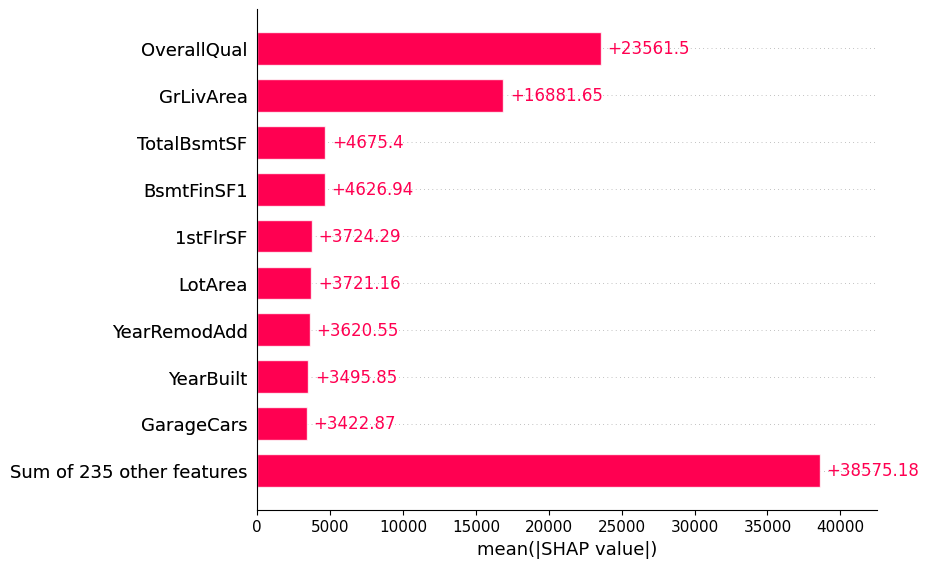

In [18]:
explainer = shap.Explainer(model)
shap_values = explainer(X_train)

shap.plots.bar(shap_values)

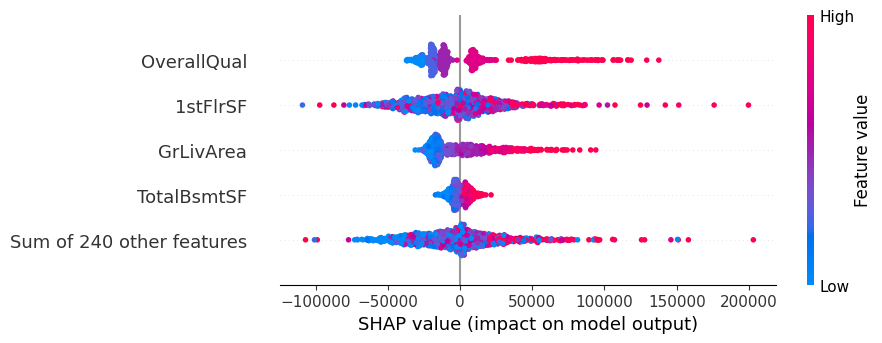

In [20]:
shap.plots.beeswarm(shap_values, max_display=5)

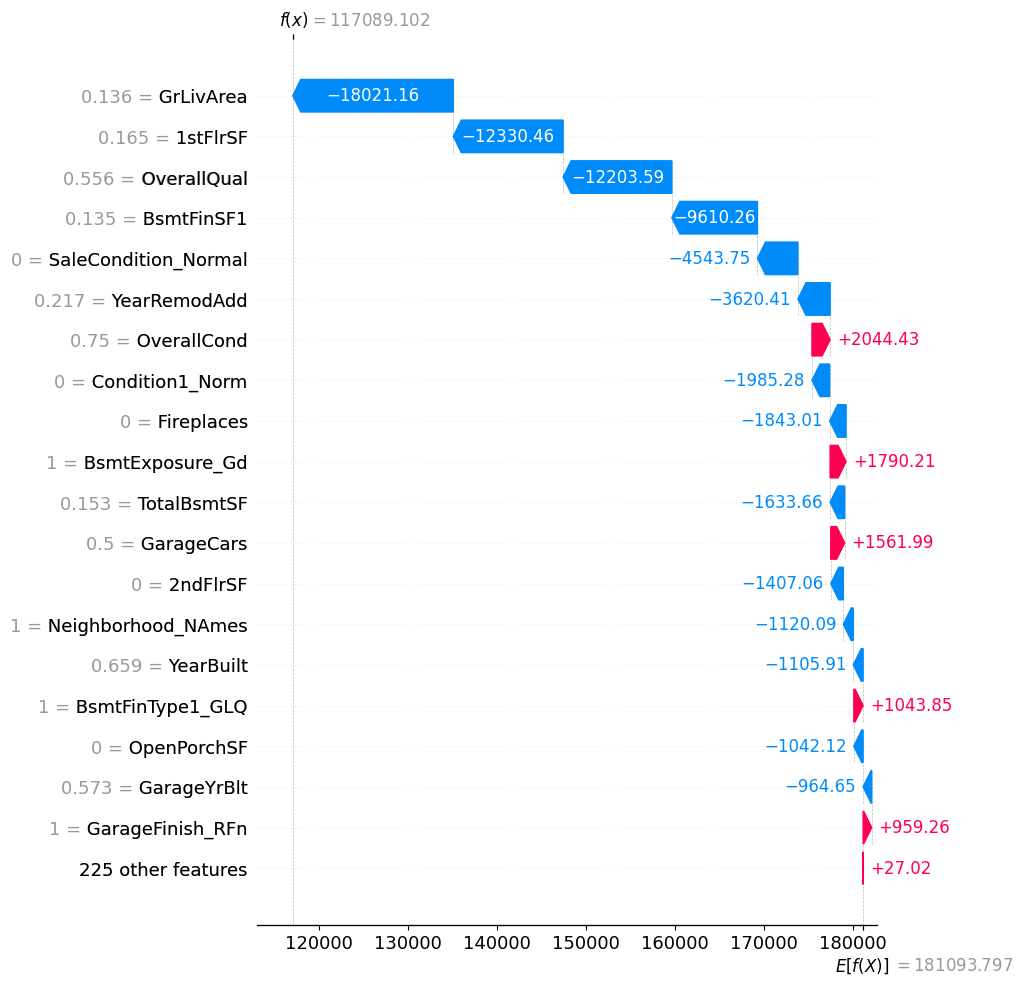

In [21]:
# visualize the first prediction's explanation
shap.plots.waterfall(shap_values[0], max_display=20)

In [24]:
check[0]

137499.97